<div>
<img src='https://upload.wikimedia.org/wikipedia/commons/6/64/Sharif_University_Logo.jpg' alt="SUT logo" width=220 height=220 align=left class="saturate">

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<!-- <font color=0F5298 size=7> -->
<font color=0F5298 size=6>
    Introduction to Machine Learning <br> <br>
<!-- <font color=2565AE size=5> -->
<font size=5>
    Computer Engineering Department <br>
    Spring 2023 <br> <br>
<font color=606060 size=5>
    Homeworks 8 & 9 (Combined): Practical - Faces <br> <br>
<font color=686880 size=4>
    TAs: Arman Malekzadeh - Amirhossein Ramazani Bonab - Yalda Shabanzadeh
    
____

### Full Name : Reza Soumi
### Student Number : 98105857
### Colab Link: https://colab.research.google.com/drive/1KyNg_v50b9YVjsO5TxcHOwK3kSLTOJaU?usp=sharing
___

In this assignment, you'll be dealing with a dataset consisting of 400 faces, belonging to 40 people. Your main task is to train models capable of recognizing those faces.
The faces are `jpg` images packed together as a zip file called `images.zip`, and the `meta.csv` determines from which person each image was taken.

In [1]:
!wget -O images.zip https://www.dropbox.com/s/wrias0bjyte3rr2/images.zip?dl=1
!wget -O meta.csv https://www.dropbox.com/s/vqt1v8sfmz18rcf/faces-metadata.csv?dl=1

--2023-06-26 17:11:00--  https://www.dropbox.com/s/wrias0bjyte3rr2/images.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/wrias0bjyte3rr2/images.zip [following]
--2023-06-26 17:11:00--  https://www.dropbox.com/s/dl/wrias0bjyte3rr2/images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaa0b6679aa8e74782911fc6bd9.dl.dropboxusercontent.com/cd/0/get/B-uQJfn8gf2eApZvUiGFHKfkGL7Mu8sP3a3dfQcUwWohLSDYSESPVKFIOZVpZvxyK7YlDaXAkiSXV33x23wmdfaQzDQV5FVfEbeByPBEfZnp-AewFj4L_CWFPksjOU-ayTC8eM-V5yLInfT7NgZNkw2jjTqqujOw5SYv48ePQpqF3J138ohlfSlaWQ3wOk28MwQ/file?dl=1# [following]
--2023-06-26 17:11:01--  https://ucaa0b6679aa8e74782911fc6bd9.dl.dropboxusercontent.com/cd/0/get/B-uQJfn8gf2eApZvUiGFHKfkGL7Mu8sP3a3dfQcUwWohLSDYSESPVKFIOZVpZv

In [2]:
# you can use the following packages
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from typing import List
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import zipfile

# Sec 1: Data Preparation

Load all images as a numpy array (called `x`) and the metadata as a dataframe **(P1-1: 25 points)**

In [32]:
with zipfile.ZipFile('images.zip', 'r') as zip_ref:
    zip_ref.extractall('images')
PATH = "images/content/img-data/"

metadata = pd.read_csv('meta.csv')

image_paths = metadata['path'].tolist()
x = np.array([np.array(Image.open(PATH+path)) for path in image_paths])

Flatten and normalize the images **(P1-2: 10 points)**

Note: For this part, normalization only means dividing by 255.

In [33]:
x_flat = x.reshape(x.shape[0], -1)

x_normalized = x_flat / 255.0

Encode the labels using `LabelEncoder` and save the result as a numpy array called `y` **(P1-3: 5 points)**

In [34]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(metadata['label'])

Split the data into training (80%), validation (10%), and testing (10%) parts. **(P1-4: 10 points)**

Note: The split procedure should maintain the class balance. This is sometimes called "[stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling)".

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.2, stratify=y, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Sec 2: SVM

## Subsec 2.1.

Train a SVM using `sklearn`. Note that the hyperparameter tuning should be done using the "validation" set. **(P2-1-1: 20 points)**

In [ ]:
svm = SVC()
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 'scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(x_train, y_train)

best_params, best_score = 0, 0
for i in range(len(grid_search.cv_results_['params'])):
    params = grid_search.cv_results_['params'][i]

    svm = SVC(**params)
    svm.fit(x_train, y_train)

    y_pred = svm.predict(x_val)

    f1 = f1_score(y_val, y_pred, average='weighted')
    if f1 > best_score:
        best_score = f1
        best_params = params

print(best_params)
svm = SVC(**best_params)
svm.fit(x_train, y_train)

accuracy = svm.score(x_val, y_val)
print(accuracy)

{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
0.975


Report the accuracy and F1-score of the classifier on the testing set **(P2-1-2: 10 points)**

In [ ]:
y_pred = grid_search.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1-score:", f1)

Accuracy: 0.975
F1-score: 0.975


## Subsec 2.2.

Train a SVM from scratch using the following class **(P2-2-1: 40 points)**

Note: For this part, you are not required to use the validation set for hyperparameter tuning. However, you might get better results if you do that.

In [108]:
from cvxopt import matrix, solvers

class SVM:
    def __init__(self):
        self.support_vectors = None
        self.weights = None
        self.bias = None
        self.num_classes = None

    def fit(self, X, y):
        """Fit the SVM model to dataset X in one-vs-one manner.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Training labels, where `n_samples` is the number of samples.

        Returns
        -------
        self : object
            Returns the instance itself.
        """

        num_samples, num_features = X.shape
        self.num_classes = len(np.unique(y))
        self.support_vectors = []
        self.weights = []
        self.bias = []

        for class_a in range(self.num_classes):
            for class_b in range(class_a + 1, self.num_classes):
                mask = np.logical_or(y == class_a, y == class_b)
                X_ab = X[mask]
                y_ab = y[mask]
                y_ab = np.where(y_ab == class_a, -1, 1)  # Label class_a as -1 and class_b as 1

                alpha = self._solve_qp(X_ab, y_ab)

                support_vector_indices = alpha > 0
                self.support_vectors.append(X_ab[support_vector_indices])
                self.weights.append(np.sum(alpha[:, np.newaxis] * (y_ab[:, np.newaxis] * X_ab), axis=0))

                bias = np.mean(y_ab[support_vector_indices] - np.dot(X_ab[support_vector_indices], self.weights[-1]))
                self.bias.append(bias)

        return self

    def transform(self, X):
        """Fit the model with X and apply the dimensionality reduction on X. SVM is one-vs-one manner and there is
        self.support_vectors = None
        self.weights = None
        self.bias = None
        from training phase

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        y_pred : ndarray of shape (n_samples)
            Your predictions for the class of each sample
        """

        num_samples = X.shape[0]
        num_classes = self.num_classes

        y_pred = []
        for x in X:
            a = 0
            x_score = [0] * num_classes
            for class_a in range(self.num_classes):
                for class_b in range(class_a + 1, self.num_classes):
                    score = np.dot(x, self.weights[a]) + self.bias[a]
                    if score > 0:
                        x_score[class_b] += 1
                    else:
                        x_score[class_a] += 1
                    a += 1
            y_pred.append(np.argmax(x_score))

        return y_pred

    def _solve_qp(self, X, y):
        num_samples, num_features = X.shape

        P = matrix(np.dot(X, X.T) * np.outer(y, y))
        q = matrix(-np.ones(num_samples))
        G = matrix(-np.eye(num_samples))
        h = matrix(np.zeros(num_samples))
        A = matrix(y.reshape(1, -1), tc='d')
        b = matrix(0.0)

        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alpha = np.array(solution['x']).flatten()
        return alpha

svm_model = SVM()

svm_model.fit(x_train, y_train)

Report the accuracy and F1-score of the classifier on the testing set **(P2-2-2: 10 points)**

In [150]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = svm_model.transform(x_test)
print(y_pred)
print(y_test)
accuracy = accuracy_score(y_pred, y_test)
f1_micro = f1_score(y_pred, y_test, average='micro')
f1_macro = f1_score(y_pred, y_test, average='macro')
print("\nAccuracy on test set: {:.2f}".format(accuracy))
print("F1_micro on test set: {:.2f}".format(f1_micro))
print("F1_macro on test set: {:.2f}".format(f1_macro))

[29, 22, 12, 16, 4, 10, 9, 26, 5, 12, 37, 18, 23, 30, 0, 28, 35, 21, 7, 11, 34, 36, 19, 1, 33, 32, 25, 31, 13, 38, 24, 3, 17, 8, 20, 6, 2, 14, 15, 27]
[29 22 30 16  4 10  9 26  5 12 37 18 23 30  0 28 35 21  7 11 34 36 19  1
 33 32 25 31 13 38 24  3 17  8 20  6  2 14 15 27]

Accuracy on test set: 0.97
F1_micro on test set: 0.97
F1_macro on test set: 0.98


# Sec 3: PCA

Fetch all images taken from `jones`, `taylor`, `anderson` and `wilson` (use the `labelencoder` object). Perform PCA from scratch using the following `class` to reduce the dimension of those images to 3. Save the results as a `numpy` array of shape `(40, 3)`. **(P3-1: 30 points)**

In [111]:
print(x_flat.shape)

(400, 4096)


In [122]:
target_names = ['jones', 'taylor', 'anderson', 'wilson']
target_indices = np.where(np.isin(y, label_encoder.transform(target_names)))
x_target = x_flat[target_indices]
y_target = y[target_indices]

In [124]:
print(x_target.shape)

(40, 4096)


In [133]:
print(y_target.shape)

(40,)


In [125]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components_ = None

    def fit(self, X):
        """Fit the model with X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        X_centered = X - np.mean(X, axis=0)

        cov_matrix = np.cov(X_centered, rowvar=False)

        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        self.components_ = sorted_eigenvectors[:, :self.n_components]

        return self

    def transform(self, X):
        """Fit the model with X and apply the dimensionality reduction on X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        X_new : ndarray of shape (n_samples, n_components)
            Transformed values.
        """
        assert self.components_ is not None

        X_centered = X - np.mean(X, axis=0)

        X_transformed = np.dot(X_centered, self.components_)

        return X_transformed

In [126]:
pca = PCA(3)
pca.fit(x_target)
x_pca = pca.transform(x_target)

In [128]:
print(x_pca.shape)

(40, 3)


Use `plotly` to plot these 3D samples. You should use their labels as the determiner of their color. **(P3-2: 10 points)**

<div>
By running this cell, pca_plot.html will create. It is attached with this notebook.
</div>

In [148]:
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

x_pca_real = np.real(x_pca)

df = pd.DataFrame({
    'PC1': x_pca_real[:, 0],
    'PC2': x_pca_real[:, 1],
    'PC3': x_pca_real[:, 2],
    'Label': label_encoder.inverse_transform(y_target)
})

df['Color'] = label_encoder.transform(df['Label'])

colors = ['blue', 'red', 'green', 'yellow']
colormap = {label: color for label, color in zip(df['Label'].unique(), colors)}

fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Color', color_discrete_map=colormap)

fig.update_layout(scene=dict(xaxis_title='Principal Component 1', yaxis_title='Principal Component 2', zaxis_title='Principal Component 3'))

fig.write_html('pca_plot.html')

# Sec 4: K-Means

Using K-means, we want to perform clustering on the 3D samples. Consider 4 clusters. After running the K-means algorithm on the data, determine to which cluster each sample belongs. Then, use `plotly` to plot the 3D samples colored with respect to their clusters. **(P4-1: 15 points)**

In [ ]:
def convert_to_2d_tsne(vecs : List):

    vecs = np.array(vecs)
    tsne = TSNE(n_components=2)

    vecs_2d = tsne.fit_transform(vecs)

    return vecs_2d

images_2d = np.array(convert_to_2d_tsne(x_normalized))

In [ ]:
def plot_docs(vecs_2d: List, labels : List):

    unique_labels = np.unique(labels)

    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    fig, ax = plt.subplots()

    for i, label in enumerate(unique_labels):
        vecs_2d_cluster = vecs_2d[labels == label]
        ax.scatter(vecs_2d_cluster[:, 0], vecs_2d_cluster[:, 1], c=colors[i], label=label)

    ax.legend()
    plt.show()

In [ ]:
class KMeans:
    """
    Fits it on data, then uses predict to get cluster labels.
    """

    def __init__(self):
        self.centroids = None
        self.labels = None
        self.true_labels = None

    def fit(self, x, y, n_clusters):
        """Fits the training data
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Training samples
        y : array-like, shape = [n_samples, n_target_values]
            Target values
        Returns
        -------
        self : object
        """
        self.true_labels = y

        x = np.array(x)
        self.centroids = x[np.random.choice(x.shape[0], n_clusters, replace=False)]

        for i in range(100):
            distances = np.sqrt(((x - self.centroids[:, np.newaxis])**2).sum(axis=2))
            self.labels = np.argmin(distances, axis=0)

            for j in range(n_clusters):
                self.centroids[j] = x[self.labels == j].mean(axis=0)

        return self

    def predict(self, x):
        """ Predicts the cluster label
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Test samples
        Returns
        -------
        Predicted cluster label
        """

        distances = np.sqrt(((x - self.centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        return labels

<ipython-input-50-234b8003d354>:11: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



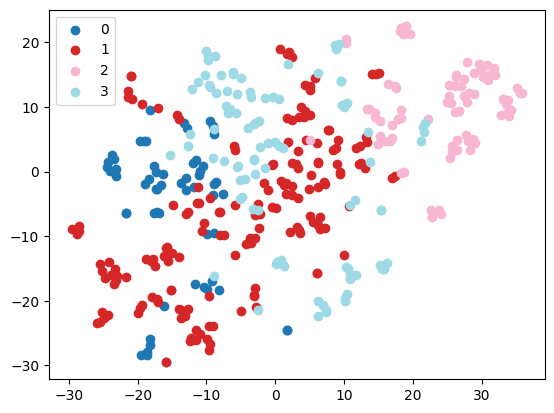

In [ ]:
k_means = KMeans()
k_means.fit(x_normalized, y, n_clusters=4)
cluster_labels = k_means.labels
plot_docs(images_2d, cluster_labels)

Measure the quality of the clustering using "silhoutte score" **(P4-2: 5 points)**

Note: You can use `sklearn` or other packages to calculate the score.

In [ ]:
silhouette_score = silhouette_score(images_2d, cluster_labels)
print(silhouette_score)

0.073922046


Compare the result of the clustering with the original labels. To be more precise, in this part, you should clearly answer the following questions with details:<br>

- Does each cluster represent a true label?
- What is your conclusion?

**(P4-3: 10 points)**

In [ ]:
predicted_labels = k_means.labels
true_labels = k_means.true_labels

cluster_majority_labels = {}

for cluster in np.unique(predicted_labels):
    cluster_samples = true_labels[predicted_labels == cluster]
    majority_label = np.argmax(np.bincount(cluster_samples))
    cluster_majority_labels[cluster] = majority_label

for cluster, majority_label in cluster_majority_labels.items():
    print(f"Cluster {cluster}: Majority Label - {majority_label}/{len(unique_labels)}")
    cluster_samples = true_labels[predicted_labels == cluster]
    unique_labels, label_counts = np.unique(cluster_samples, return_counts=True)
    print(f"   True Labels: {unique_labels}")
    print(f"   Label Counts: {label_counts}\n")

Cluster 0: Majority Label - 11/25
   True Labels: [ 1  3  5  6  9 11 17 20 22 24 26 34 36 37 38]
   Label Counts: [ 3  9  8  6  2 10  5  2  1  1  1  2  1  2  5]

Cluster 1: Majority Label - 4/15
   True Labels: [ 0  1  2  3  4  5  6  7  8  9 10 12 15 17 18 19 22 23 24 26 28 29 30 32
 33 34 35 36 37 38]
   Label Counts: [ 1  6  5  1 10  1  3  7 10  6 10  3  9  2  4 10  9  9  5  9  3  8  6  4
 10  3  2  4  5  4]

Cluster 2: Majority Label - 13/30
   True Labels: [12 13 14 16 18 21 25 27 28 30 31 35]
   Label Counts: [ 4 10 10  6  1  7 10 10  3  5 10  2]

Cluster 3: Majority Label - 0/12
   True Labels: [ 0  1  2  5  6  7  9 12 15 16 17 18 20 21 23 24 28 29 30 32 34 35 36 37
 38]
   Label Counts: [9 1 5 1 1 3 2 3 1 4 3 5 8 3 1 4 4 2 9 6 5 6 5 3 1]



<div>
Does each cluster represent a true label?

Ideally, in a perfect clustering scenario, each cluster would represent a distinct true label. However, in reality, it is not guaranteed that each cluster will align perfectly with the true labels. The quality of the clustering depends on the inherent structure of the data and the effectiveness of the algorithm.

What is your conclusion?

The accuracy score obtained from comparing the clustering results with the original labels provides a measure of how well the clusters align with the true labels. A higher accuracy score indicates a better alignment. If the accuracy score is close to 1, it suggests that the clusters represent the true labels well. On the other hand, if the accuracy score is low, it indicates that the clustering did not capture the true label structure effectively.
</div>

# Sec 5: Neural Net (Optional with Bonus Points)

Reshape the images so that they become of shape `64x64` **(P5-1: 5 points)**

In [17]:
x_train = x_train.reshape(-1, 64, 64)
x_val = x_val.reshape(-1, 64, 64)
x_test = x_test.reshape(-1, 64, 64)

In [18]:
x_train[0].shape

(64, 64)

Use different types of augmentation techniques (such as Random Flipping, Random Rotation, etc.) to increase the size of the training dataset. **(P5-2: 10 points)**

In [20]:
from keras.preprocessing.image import ImageDataGenerator

x_train = x_train.reshape(-1, 64, 64, 1)

datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(x_train)

augmented_data = datagen.flow(x_train, y_train, batch_size=32)

In [27]:
total_num_augmented_images = len(augmented_data) * augmented_data.batch_size
print("Total number of augmented images:", total_num_augmented_images)


Total number of augmented images: 320


In [22]:
type(augmented_data)

keras.preprocessing.image.NumpyArrayIterator

Using the augmented training set, train a neural network consisting of 2D convolutional layers. The exact architecture of the network is arbitrary. However, the last layer should have the "softmax" function as its activation. Also, using "max pooling" layers after convolutional ones is advised.

Note: Don't get frustrated if your network does not appear to be a good one. Give it some time to be trained. For instance, you might need to train it for 100 epochs. Make sure to try that out before quitting!

**(P5-3: 20 points)**

In [30]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(40, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(augmented_data, epochs=150, validation_data=(x_val, y_val))

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Epoch 1/150
10/10 [==============================] - 3s 217ms/step - loss: 3.7305 - accuracy: 0.0125 - val_loss: 3.6874 - val_accuracy: 0.0250
Epoch 2/150
10/10 [==============================] - 2s 192ms/step - loss: 3.6879 - accuracy: 0.0156 - val_loss: 3.6851 - val_accuracy: 0.0250
Epoch 3/150
10/10 [==============================] - 3s 303ms/step - loss: 3.6862 - accuracy: 0.0437 - val_loss: 3.6787 - val_accuracy: 0.0500
Epoch 4/150
10/10 [==============================] - 2s 186ms/step - loss: 3.6815 - accuracy: 0.0500 - val_loss: 3.6714 - val_accuracy: 0.0500
Epoch 5/150
10/10 [==============================] - 2s 179ms/step - loss: 3.6783 - accuracy: 0.0500 - val_loss: 3.6617 - val_accuracy: 0.0500
Epoch 6/150
10/10 [==============================] - 2s 189ms/step - loss: 3.6693 - accuracy: 0.0500 - val_loss: 3.6510 - val_accuracy: 0.0500
Epoch 7/150
10/10 [==============================] - 3s 258ms/step - loss: 3.6536 - accuracy: 0.0500 - val_loss: 3.6364 - val_accuracy: 0.0500

Measure the accuracy of the network on the validation and testing datasets **(P5-4: 5 points)**

In [31]:
val_loss, val_acc = model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2/2 [==============================] - 0s 38ms/step - loss: 0.3830 - accuracy: 0.9000
Validation Loss: 0.383034884929657
Validation Accuracy: 0.8999999761581421
2/2 [==============================] - 0s 31ms/step - loss: 0.5196 - accuracy: 0.8250
Test Loss: 0.5196025967597961
Test Accuracy: 0.824999988079071
